# Pretraining of the Code Embedding by GloVe

In this notebook we try to use Keras backend implement the optimization problem of GloVe. 
$$J = \sum_{i, j=1}^{V}f(X_{ij})(\mathbf{w}_i^T\mathbf{v_j} + b_i + a_j - \log X_{ij})^2$$
$$ \mathbf{W}, \mathbf{V}, \mathbf{b}, \mathbf{a} = \text{argmin}(J)$$

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
import os, sys
from importlib import reload
import scipy.sparse as sp
import time

%matplotlib inline

In [4]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [4]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda, Multiply
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

Using TensorFlow backend.


In [6]:
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import Mat_reg, Parent_reg
from glove import Glove

In [7]:
from ccs_tools import dx_multi, pr_multi, dx_label, core_dtypes_pd

## Train Embedding with Co-occurences in AMI Cohort
### Reading Data

In [8]:
train_df = pd.read_csv(path+'cohorts/ami/DX_train.csv', dtype=core_dtypes_pd)
tst_df = pd.read_csv(path+'cohorts/ami/DX_tst.csv', dtype=core_dtypes_pd)

In [14]:
train_df.shape

(163671, 150)

In [9]:
all_df = pd.concat([train_df, tst_df])

### Define the dictionaries for DX, PR and hosp, from value to int. 

In [171]:
N_DX = 29
DXs = ['DX'+str(n) for n in range(2, N_DX+2)]

DX_series = pd.concat([all_df[DX] for DX in DXs])
DX_series = DX_series.fillna('missing')
DX_series[DX_series.isin(['invl', 'incn'])] = 'missing'

unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])
DX_series.loc[DX_series.isin(unclassified)] = 'missing'

rare_cutpoint = 1
code_freq = DX_series.value_counts()
rare_code = code_freq[code_freq<rare_cutpoint].index
DX_series.loc[DX_series.isin(rare_code)] = 'missing' # also consider coding as 'rare'

In [17]:
ami_DX = ['41000', '41001', '41010', '41011', '41020', '41021', '41030', '41031', '41040', '41041', '41050', '41051', '41060', '41061', '41070', '41071', '41080', '41081', '41090', '41091']

In [64]:
amidx_top10 = code_freq[1:11]
amidx_top20 = code_freq[1:21]
amidx_top50 = code_freq[1:51]
amidx_top100 = code_freq[1:101]

In [9]:
DX_series = DX_series.astype('category')
DX_cat = DX_series.cat.categories
n_DX_cat = len(DX_cat)
DX_int_cat = list(range(n_DX_cat)[1:]) +[0]
DX_dict = dict(zip(DX_cat, DX_int_cat))

In [10]:
n_DX_cat

5251

In [11]:
N_PR = 15
PRs = ['PR'+str(n) for n in range(1, N_PR+1)]

PR_series = pd.concat([all_df[PR] for PR in PRs])

PR_series = PR_series.fillna('missing')
PR_series[PR_series.isin(['invl', 'incn'])] = 'missing'

pr_rare_cutpoint = 1
pr_code_freq = PR_series.value_counts()
pr_rare_code = pr_code_freq[pr_code_freq<pr_rare_cutpoint].index
PR_series.loc[PR_series.isin(pr_rare_code)] = 'missing' # also consider coding as 'rare'

PR_series = PR_series.astype('category')
PR_cat = PR_series.cat.categories
n_PR_cat = len(PR_cat)

PR_int_cat = list(np.array(range(n_PR_cat)[:-1])+n_DX_cat) + [0]

PR_dict = dict(zip(PR_cat, PR_int_cat))

In [12]:
n_PR_cat

1260

In [13]:
code_lst = ['missing']+list(DX_cat[:-1])+list(PR_cat[:-1])

In [14]:
len(code_lst), n_PR_cat+n_DX_cat

(6510, 6511)

In [17]:
DX_df = train_df[DXs]

DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
#DX_df[DX_df.isin(rare_code)] = 'missing'
DX_df[DX_df.isin(unclassified)] = 'missing'

for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)

#DX_mat = DX_df.values

In [18]:
PR_df = train_df[PRs]

PR_df = PR_df.fillna('missing')
PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
#PR_df[PR_df.isin(pr_rare_code)] = 'missing'

for pr in PRs:
    PR_df[pr] = PR_df[pr].map(PR_dict)

#PR_mat = PR_df.values

In [19]:
code_df = pd.concat([DX_df, PR_df], axis=1)

In [7]:
from glove import Glove

In [16]:
g = Glove(input_dim=n_code_cat, embedding_dim=100)

In [20]:
g.update_cooccur(code_df)

Updating co-occurrence matrix from a Dataframe with 163671 rows...
Finished. It takes 26.6 seconds to update the cooccurrences.


In [34]:
cooccur_df = g.get_cooccur_df()

In [28]:
g.train_glove(cache_path=model_path, epochs=50, reducelr_patience=3)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Train on 800963 samples, validate on 200241 samples
Epoch 1/50
800963/800963 [==============================] - 6s 7us/step - loss: 0.4747 - val_loss: 0.0537
Epoch 2/50
800963/800963 [==============================] - 5s 7us/step - loss: 0.0492 - val_loss: 0.0421
Epoch 3/50
800963/800963 [==============================] - 5s 7us/step - loss: 0.0359 - val_loss: 0.0324
Epoch 4/50
800963/800963 [==============================] - 5s 7us/step - loss: 0.0278 - val_loss: 0.0265
Epoch 5/50
800963/800963 [==============================] - 5s 7us/step - loss: 0.0227 - val_loss: 0.0226
Epoch 6/50
800963/800963 [==============================] - 5s 7us/step - loss: 0.0193 - val_loss: 0.0204
Epoch 7/50
800963/800963 [==============================] - 5s 7us/step - loss: 0.0170 - val_loss: 0.0189
Epoch 8/50
800963/800963 [==============================] - 5s 7us/step - loss: 0.0154 - val_loss: 0.0180
Epoch 9/50
800963/800963 [

In [31]:
embed_mat = g.get_embed_mat()

In [33]:
np.save(path+'cohorts/ami/embed_mat_ami0824.npy', embed_mat)

## Get the cooccurrences from the whole database

In [9]:
from ccs_tools import dx_multi, pr_multi
from glove import Glove
from ccs_tools import core_cols, core_dtypes_pd, na_values

### Not separate DX1

In [9]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)

n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)

DX_dict = dict(zip(DX_cat, range(len(DX_cat))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat), len(DX_cat)+len(PR_cat)))))

n_DX = 30
n_PR = 15
DXs = ['DX'+str(j) for j in range(1, n_DX+1)]
PRs = ['PR'+str(j) for j in range(1, n_PR+1)]

In [10]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

In [11]:
code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE) + sorted(pr_multi.ICD9CM_CODE)
n_code_cat = len(code_cat)

In [17]:
g = Glove(input_dim=len(code_cat), embedding_dim=100)

In [18]:
dxpr_df = pd.read_csv(path+'raw/2014/NRD_2014_Core.CSV', sep=',', 
                           header = None, 
                           names=core_cols, 
                           dtype=core_dtypes_pd, 
                           na_values=na_values, 
                           chunksize=500000)

In [19]:
chunk_id = 0
for df in dxpr_df:
    start = time.time()
    DX_df = df[DXs]
    DX_df = DX_df.fillna('missing')
    DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
    DX_df[DX_df.isin(unclassified)] = 'missing'
    for dx in DXs:
        DX_df[dx] = DX_df[dx].map(DX_dict)
        
    PR_df = df[PRs]
    PR_df = PR_df.fillna('missing')
    PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
    for pr in PRs:
        PR_df[pr] = PR_df[pr].map(PR_dict)
        
    df = pd.concat([DX_df, PR_df], axis=1)
    g.update_cooccur(df)
    print('Chunk {} finished. It takes {:.1f} seconds.'.format(chunk_id, time.time()-start))
    chunk_id += 1

Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 67.0 seconds to update the cooccurrences.
Chunk 0 finished. It takes 75.6 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 66.6 seconds to update the cooccurrences.
Chunk 1 finished. It takes 77.6 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 68.1 seconds to update the cooccurrences.
Chunk 2 finished. It takes 79.3 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 67.6 seconds to update the cooccurrences.
Chunk 3 finished. It takes 79.1 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 64.4 seconds to update the cooccurrences.
Chunk 4 finished. It takes 76.1 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 62.7 seconds to update the cooccurrences.
Chunk 5 finished. It takes 

In [11]:
cooccur_df = pd.read_csv(path+'all/cooccur_df.csv')

In [12]:
cooccur_df.shape

(12866672, 3)

In [14]:
g.train_glove(cooccur_df=cooccur_df, cache_path=model_path, epochs=20)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Train on 10293337 samples, validate on 2573335 samples
Epoch 1/20
10293337/10293337 [==============================] - 61s 6us/step - loss: 0.2768 - val_loss: 0.0678
Epoch 2/20
10293337/10293337 [==============================] - 59s 6us/step - loss: 0.0531 - val_loss: 0.0455
Epoch 3/20
10293337/10293337 [==============================] - 59s 6us/step - loss: 0.0410 - val_loss: 0.0410
Epoch 4/20
10293337/10293337 [==============================] - 59s 6us/step - loss: 0.0374 - val_loss: 0.0398
Epoch 5/20
10293337/10293337 [==============================] - 59s 6us/step - loss: 0.0358 - val_loss: 0.0393
Epoch 6/20
10293337/10293337 [==============================] - 59s 6us/step - loss: 0.0349 - val_loss: 0.0390
Epoch 7/20
10293337/10293337 [==============================] - 59s 6us/step - loss: 0.0344 - val_loss: 0.0390
Epoch 8/20
10293337/10293337 [==============================] - 59s 6us/step - loss: 0.0340 - 

In [20]:
cooccur_dict = g.get_cooccur_dict()

### Co-Occurence Matrices for cross-validation

In [23]:
ami_df = pd.read_csv(path+'cohorts/ami/ami_pred.csv', dtype=core_dtypes_pd)

In [39]:
for seed in range(1,10):
    print('Starting seed'+str(seed))
    train_df, tst_df = train_test_split(ami_df, test_size=0.1, stratify=ami_df.HOSP_NRD, random_state=seed)

    DX_df = tst_df[DXs]
    DX_df = DX_df.fillna('missing')
    DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
    DX_df[DX_df.isin(unclassified)] = 'missing'
    for dx in DXs:
        DX_df[dx] = DX_df[dx].map(DX_dict)
        
    PR_df = tst_df[PRs]
    PR_df = PR_df.fillna('missing')
    PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
    for pr in PRs:
        PR_df[pr] = PR_df[pr].map(PR_dict)
        
    int_df = pd.concat([DX_df, PR_df], axis=1)

    g2 = Glove(input_dim=len(code_cat), embedding_dim=100)

    g2.update_cooccur(int_df)

    cooccur_dict_tst = g2.get_cooccur_dict()

    cooccur_dict0 = cooccur_dict.copy()

    for k, v in cooccur_dict_tst.items():
        cooccur_dict0[k] -= v
    print('Converting to cooccur_df...')
    pairs = list(cooccur_dict0.keys())
    counts = list(cooccur_dict0.values())
    focal, context = zip(*pairs)
    cooccur_df0 = pd.DataFrame(dict(focal_index=focal, context_index=context, cooccur_counts=counts), 
                              columns=['focal_index', 'context_index', 'cooccur_counts'])

    cooccur_df0.to_csv(path+'all/cooccur_df_ami'+str(seed)+'.csv', index=False)

Starting seed1
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 3.3 seconds to update the cooccurrences.
Converting to cooccur_df...
Starting seed2
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 3.2 seconds to update the cooccurrences.
Converting to cooccur_df...
Starting seed3
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 3.2 seconds to update the cooccurrences.
Converting to cooccur_df...
Starting seed4
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 3.2 seconds to update the cooccurrences.
Converting to cooccur_df...
Starting seed5
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 3.2 seconds to update the cooccurrences.
Converting to cooccur_df...
Starting seed6
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 3.2 seconds to update the cooccurrences.
Converting to 

### Separate DX1

In [10]:
DX1_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)
code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE) + sorted(dx_multi.ICD9CM_CODE) + sorted(pr_multi.ICD9CM_CODE)

n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)
n_code_cat = len(code_cat)

DX1_dict = dict(zip(DX1_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))

DXs = ['DX'+str(j) for j in range(2, 31)]
PRs = ['PR'+str(j) for j in range(1, 16)]

In [11]:
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

In [14]:
g = Glove(input_dim=len(code_cat), embedding_dim=100)

In [11]:
dxpr_df = pd.read_csv(path+'raw/2014/NRD_2014_Core.CSV', sep=',', 
                           header = None, 
                           names=core_cols, 
                           dtype=core_dtypes_pd, 
                           na_values=na_values, 
                           chunksize=500000)

In [15]:
chunk_id = 0
for df in dxpr_df:
    start = time.time()
    DX1_df = df[['DX1']]
    DX1_df = DX1_df.fillna('missing')
    DX1_df[DX1_df.isin(['invl', 'incn'])] = 'missing'
    DX1_df[DX1_df.isin(unclassified)] = 'missing'
    DX1_df['DX1'] = DX1_df['DX1'].map(DX1_dict)
    
    DX_df = df[DXs]
    DX_df = DX_df.fillna('missing')
    DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
    DX_df[DX_df.isin(unclassified)] = 'missing'
    for dx in DXs:
        DX_df[dx] = DX_df[dx].map(DX_dict)
        
    PR_df = df[PRs]
    PR_df = PR_df.fillna('missing')
    PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
    for pr in PRs:
        PR_df[pr] = PR_df[pr].map(PR_dict)
        
    df = pd.concat([DX1_df, DX_df, PR_df], axis=1)
    g.update_cooccur(df)
    print('Chunk {} finished. It takes {:.1f} seconds.'.format(chunk_id, time.time()-start))
    chunk_id += 1

Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 83.0 seconds to update the cooccurrences.
Chunk 0 finished. It takes 93.2 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 80.6 seconds to update the cooccurrences.
Chunk 1 finished. It takes 93.7 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 83.6 seconds to update the cooccurrences.
Chunk 2 finished. It takes 96.0 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 84.7 seconds to update the cooccurrences.
Chunk 3 finished. It takes 98.9 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 82.5 seconds to update the cooccurrences.
Chunk 4 finished. It takes 96.6 seconds.
Updating co-occurrence matrix from a Dataframe with 500000 rows...
Finished. It takes 80.6 seconds to update the cooccurrences.
Chunk 5 finished. It takes 

In [16]:
cooccur_dict = g.get_cooccur_dict()

### Co-Occurence Matrices for cross-validation

In [20]:
ami_df = pd.read_csv(path+'cohorts/ami/ami_pred.csv', dtype=core_dtypes_pd)

In [26]:
for seed in range(1,10):
    print('Starting seed'+str(seed))
    train_df, tst_df = train_test_split(ami_df, test_size=0.1, stratify=ami_df.HOSP_NRD, random_state=seed)

    DX1_df = tst_df[['DX1']]
    DX1_df = DX1_df.fillna('missing')
    DX1_df[DX1_df.isin(['invl', 'incn'])] = 'missing'
    DX1_df[DX1_df.isin(unclassified)] = 'missing'
    DX1_df['DX1'] = DX1_df['DX1'].map(DX1_dict)
    
    DX_df = tst_df[DXs]
    DX_df = DX_df.fillna('missing')
    DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
    DX_df[DX_df.isin(unclassified)] = 'missing'
    for dx in DXs:
        DX_df[dx] = DX_df[dx].map(DX_dict)
        
    PR_df = tst_df[PRs]
    PR_df = PR_df.fillna('missing')
    PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
    for pr in PRs:
        PR_df[pr] = PR_df[pr].map(PR_dict)
        
    int_df = pd.concat([DX1_df, DX_df, PR_df], axis=1)

    g2 = Glove(input_dim=len(code_cat), embedding_dim=100)

    g2.update_cooccur(int_df)

    cooccur_dict_tst = g2.get_cooccur_dict()

    cooccur_dict0 = cooccur_dict.copy()

    for k, v in cooccur_dict_tst.items():
        cooccur_dict0[k] -= v
    print('Converting to cooccur_df...')
    pairs = list(cooccur_dict0.keys())
    counts = list(cooccur_dict0.values())
    focal, context = zip(*pairs)
    cooccur_df0 = pd.DataFrame(dict(focal_index=focal, context_index=context, cooccur_counts=counts), 
                              columns=['focal_index', 'context_index', 'cooccur_counts'])
    cooccur_df0 = cooccur_df0.loc[cooccur_df0.cooccur_counts>0]
    cooccur_df0.to_csv(path+'all/sepdx1/cooccur_df_ami'+str(seed)+'.csv', index=False)

Starting seed1
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 4.8 seconds to update the cooccurrences.
Converting to cooccur_df...


KeyboardInterrupt: 

### Cooccurrence between DX1 and DX

In [10]:
DX1_int_set = set(DX1_dict.values())

In [11]:
DX1_DX_df = cooccur_df.loc[cooccur_df.context_index.isin(DX1_int_set)]

In [21]:
DX_cooccur_df = cooccur_df.loc[~cooccur_df.context_index.isin(DX1_int_set)]

In [31]:
g.train_glove(cooccur_df=DX_cooccur_df, cache_path=model_path, epochs=50)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Train on 9528371 samples, validate on 2382093 samples
Epoch 1/50
9528371/9528371 [==============================] - 62s 7us/step - loss: 0.2679 - val_loss: 0.0617
Epoch 2/50
9528371/9528371 [==============================] - 62s 7us/step - loss: 0.0484 - val_loss: 0.0414
Epoch 3/50
9528371/9528371 [==============================] - 62s 7us/step - loss: 0.0372 - val_loss: 0.0370
Epoch 4/50
9528371/9528371 [==============================] - 62s 6us/step - loss: 0.0338 - val_loss: 0.0359
Epoch 5/50
9528371/9528371 [==============================] - 62s 7us/step - loss: 0.0323 - val_loss: 0.0355
Epoch 6/50
9528371/9528371 [==============================] - 62s 6us/step - loss: 0.0315 - val_loss: 0.0354
Epoch 7/50
9528371/9528371 [==============================] - 62s 7us/step - loss: 0.0309 - val_loss: 0.0354
Epoch 8/50
9528371/9528371 [==============================] - 62s 6us/step - loss: 0.0306 - val_loss: 0.0352


In [32]:
embed_mat = g.get_embed_mat()

In [34]:
np.save(path+'all/embed_mat_secondary.npy', embed_mat)

In [12]:
secondary_embed_mat = np.load(path+'all/embed_mat_secondary.npy')

In [23]:
g = Glove(input_dim=n_code_cat, embedding_dim=100)

In [24]:
g.train_glove_double(cooccur_df=DX1_DX_df, cache_path=model_path, focal_initializer=Constant(secondary_embed_mat), 
                     focal_trainable=False, reducelr_patience=5)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Train on 4184553 samples, validate on 1046139 samples
Epoch 1/50
4184553/4184553 [==============================] - 29s 7us/step - loss: 0.3180 - val_loss: 0.0661
Epoch 2/50
4184553/4184553 [==============================] - 28s 7us/step - loss: 0.0497 - val_loss: 0.0438
Epoch 3/50
4184553/4184553 [==============================] - 28s 7us/step - loss: 0.0375 - val_loss: 0.0395
Epoch 4/50
4184553/4184553 [==============================] - 29s 7us/step - loss: 0.0338 - val_loss: 0.0380
Epoch 5/50
4184553/4184553 [==============================] - 28s 7us/step - loss: 0.0322 - val_loss: 0.0375
Epoch 6/50
4184553/4184553 [==============================] - 28s 7us/step - loss: 0.0313 - val_loss: 0.0374
Epoch 7/50
4184553/4184553 [==============================] - 28s 7us/step - loss: 0.0307 - val_loss: 0.0373
Epoch 8/50
4184553/4184553 [==============================] - 28s 7us/step - loss: 0.0303 - val_loss: 0.0374


In [27]:
focal_embed, context_embed = g.get_embed_mat(double=True)

In [30]:
embed_mat = focal_embed
embed_mat[:n_DX_cat, ] = context_embed[:n_DX_cat, ]

In [31]:
np.save(path+'all/embed_mat_double.npy', embed_mat)

### Co-Occurence Matrices for cross-validation

In [10]:
ami_df = pd.read_csv(path+'cohorts/ami/ami_pred.csv', dtype=core_dtypes_pd)

In [39]:
for seed in range(1,10):
    print('Starting seed'+str(seed))
    train_df, tst_df = train_test_split(ami_df, test_size=0.1, stratify=ami_df.HOSP_NRD, random_state=seed)

    DX_df = tst_df[DXs]
    DX_df = DX_df.fillna('missing')
    DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
    DX_df[DX_df.isin(unclassified)] = 'missing'
    for dx in DXs:
        DX_df[dx] = DX_df[dx].map(DX_dict)
        
    PR_df = tst_df[PRs]
    PR_df = PR_df.fillna('missing')
    PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
    for pr in PRs:
        PR_df[pr] = PR_df[pr].map(PR_dict)
        
    int_df = pd.concat([DX_df, PR_df], axis=1)

    g2 = Glove(input_dim=len(code_cat), embedding_dim=100)

    g2.update_cooccur(int_df)

    cooccur_dict_tst = g2.get_cooccur_dict()

    cooccur_dict0 = cooccur_dict.copy()

    for k, v in cooccur_dict_tst.items():
        cooccur_dict0[k] -= v
    print('Converting to cooccur_df...')
    pairs = list(cooccur_dict0.keys())
    counts = list(cooccur_dict0.values())
    focal, context = zip(*pairs)
    cooccur_df0 = pd.DataFrame(dict(focal_index=focal, context_index=context, cooccur_counts=counts), 
                              columns=['focal_index', 'context_index', 'cooccur_counts'])

    cooccur_df0.to_csv(path+'all/cooccur_df_ami'+str(seed)+'.csv', index=False)

Starting seed1
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 3.3 seconds to update the cooccurrences.
Converting to cooccur_df...
Starting seed2
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 3.2 seconds to update the cooccurrences.
Converting to cooccur_df...
Starting seed3
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 3.2 seconds to update the cooccurrences.
Converting to cooccur_df...
Starting seed4
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 3.2 seconds to update the cooccurrences.
Converting to cooccur_df...
Starting seed5
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 3.2 seconds to update the cooccurrences.
Converting to cooccur_df...
Starting seed6
Updating co-occurrence matrix from a Dataframe with 18186 rows...
Finished. It takes 3.2 seconds to update the cooccurrences.
Converting to 

In [15]:
embed_mat = g.get_embed_mat()

In [16]:
embed_mat.shape

(19021, 100)

In [24]:
np.save(path+'all/embed_mat0821.npy', embed_mat)

### Adding Multi-Level Penalization
Not separate dx1

In [8]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)

n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)

DX_dict = dict(zip(DX_cat, range(len(DX_cat))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat), len(DX_cat)+len(PR_cat)))))

unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

dx_ccs_cat = pd.concat([dx_multi.CCS_LVL1, dx_multi.CCS_LVL2, dx_multi.CCS_LVL3, dx_multi.CCS_LVL4]).astype('category').cat.categories
pr_ccs_cat = pd.concat([pr_multi.CCS_LVL1, pr_multi.CCS_LVL2, pr_multi.CCS_LVL3]).astype('category').cat.categories

code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE) + sorted(pr_multi.ICD9CM_CODE) + sorted(dx_ccs_cat)[1:] + sorted(pr_ccs_cat)[1:]
n_code_cat = len(code_cat)

dx_ccs_dict = dict(zip(dx_ccs_cat[1:], range(len(dx_multi)+len(pr_multi)+1, len(dx_multi)+len(pr_multi)+len(dx_ccs_cat))))
pr_ccs_dict = dict(zip(pr_ccs_cat[1:], range(len(dx_multi)+len(pr_multi)+len(dx_ccs_cat), n_code_cat)))

In [12]:
n_code_cat

20153

In [9]:
parent_pairs = []
for dx in DX_cat[1:]:
    if not dx in unclassified:
        parent = dx_multi.loc[dx, 'finest_non_empty']
        parent_pairs.append((DX_dict[dx], dx_ccs_dict[parent]))
for pr in PR_cat[1:]:
    parent = pr_multi.loc[pr, 'finest_non_empty']
    parent_pairs.append((PR_dict[pr], pr_ccs_dict[parent]))
for c in dx_ccs_cat[1:]:
    parent = '.'.join(c.split('.')[:-1])
    if not parent=='':
        parent_pairs.append((dx_ccs_dict[c], dx_ccs_dict[parent]))
for c in pr_ccs_cat[1:]:
    parent = '.'.join(c.split('.')[:-1])
    if not parent=='':
        parent_pairs.append((pr_ccs_dict[c], pr_ccs_dict[parent]))

In [17]:
len(parent_pairs)

18529

In [29]:
g = Glove(input_dim=len(code_cat), embedding_dim=100)

In [18]:
cooccur_df = pd.read_csv(path+'all/cooccur_df.csv')

In [84]:
cooccur_df.shape

(12866672, 3)

In [86]:
import glove
reload(glove)
from glove import Glove

In [30]:
g.train_glove(cooccur_df=cooccur_df, cache_path=model_path, epochs=20, reducelr_patience=5, parent_pairs=parent_pairs, lamb=1e-5, norm=2)

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Train on 10293337 samples, validate on 2573335 samples
Epoch 1/20
10293337/10293337 [==============================] - 67s 6us/step - loss: 0.3101 - val_loss: 0.1280
Epoch 2/20
10293337/10293337 [==============================] - 67s 7us/step - loss: 0.1187 - val_loss: 0.1111
Epoch 3/20
10293337/10293337 [==============================] - 67s 6us/step - loss: 0.1095 - val_loss: 0.1068
Epoch 4/20
10293337/10293337 [==============================] - 67s 6us/step - loss: 0.1068 - val_loss: 0.1054
Epoch 5/20
10293337/10293337 [==============================] - 67s 7us/step - loss: 0.1058 - val_loss: 0.1047
Epoch 6/20
10293337/10293337 [==============================] - 67s 7us/step - loss: 0.1053 - val_loss: 0.1046
Epoch 7/20
10293337/10293337 [==============================] - 67s 7us/step - loss: 0.1049 - val_loss: 0.1041
Epoch 8/20
10293337/10293337 [==============================] - 67s 6us/step - loss: 0.1047 - 

In [31]:
embed_mat = g.get_embed_mat()

In [16]:
embed_mat.shape

(19021, 100)

In [34]:
np.save(path+'all/embed_mat_pen0824.npy', embed_mat)

Separate DX1

In [12]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)

n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)

DX1_dict = dict(zip(DX_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))

DXs = ['DX'+str(j) for j in range(2, 31)]
PRs = ['PR'+str(j) for j in range(1, 16)]

unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])

dx_ccs_cat = pd.concat([dx_multi.CCS_LVL1, dx_multi.CCS_LVL2, dx_multi.CCS_LVL3, dx_multi.CCS_LVL4]).astype('category').cat.categories
pr_ccs_cat = pd.concat([pr_multi.CCS_LVL1, pr_multi.CCS_LVL2, pr_multi.CCS_LVL3]).astype('category').cat.categories

code_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)*2 + sorted(pr_multi.ICD9CM_CODE)+ sorted(dx_ccs_cat)[1:]*2 + sorted(pr_ccs_cat)[1:]
n_code_cat = len(code_cat)

dx1_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi), len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat))))
dx_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:]), 1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2)))
pr_ccs_dict = dict(zip(pr_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2, n_code_cat)))

In [13]:
parent_pairs = []
for dx in DX_cat[1:]:
    if not dx in unclassified:
        parent = dx_multi.loc[dx, 'finest_non_empty']
        parent_pairs.append((DX1_dict[dx], dx1_ccs_dict[parent]))
        parent_pairs.append((DX_dict[dx], dx_ccs_dict[parent]))
for pr in PR_cat[1:]:
    parent = pr_multi.loc[pr, 'finest_non_empty']
    parent_pairs.append((PR_dict[pr], pr_ccs_dict[parent]))
for c in dx_ccs_cat[1:]:
    parent = '.'.join(c.split('.')[:-1])
    if not parent=='':
        parent_pairs.append((dx1_ccs_dict[c], dx1_ccs_dict[parent]))
        parent_pairs.append((dx_ccs_dict[c], dx_ccs_dict[parent]))
for c in pr_ccs_cat[1:]:
    parent = '.'.join(c.split('.')[:-1])
    if not parent=='':
        parent_pairs.append((pr_ccs_dict[c], pr_ccs_dict[parent]))

In [9]:
g = Glove(input_dim=len(code_cat), embedding_dim=200)

In [10]:
cooccur_df = pd.read_csv(path+'all/sepdx1/cooccur_df_ami0.csv')

In [15]:
cooccur_df.shape

(17136813, 3)

In [12]:
g.train_glove(cooccur_df=cooccur_df, cache_path=model_path, epochs=30, reducelr_patience=2, parent_pairs=parent_pairs, lamb=0., 
              metric='cosine')

Preparing data...
Defining the GloVe model...
Training the GloVe model...
Epoch 1/30
17136813/17136813 [==============================] - 238s 14us/step - loss: 0.1609
Epoch 2/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0412
Epoch 3/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0362
Epoch 4/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0342
Epoch 5/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0330
Epoch 6/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0322
Epoch 7/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0317
Epoch 8/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0313
Epoch 9/30
17136813/17136813 [==============================] - 236s 14us/step - loss: 0.0309
Epoch 10/30
17136813/17136813 [==============================] - 236s 14us/step 

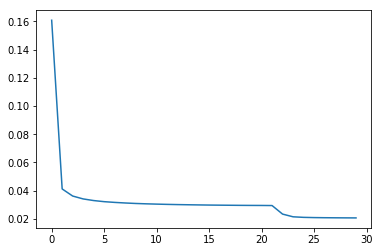

In [17]:
plt.plot(g.train_history.history['loss'])

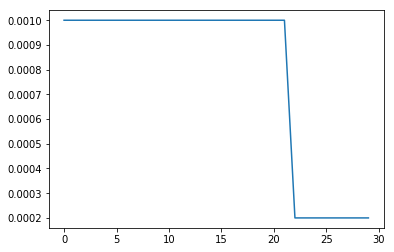

In [18]:
plt.plot(g.train_history.history['lr'])

In [20]:
embed_mat = g.get_embed_mat()

## Embedding Visualization

In [7]:
from sklearn import decomposition, manifold

In [42]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [8]:
from collections import defaultdict

In [14]:
embed_mat = np.load(path+'all/sepdx1/test_embed/cosine/embed_mat_200_0.000_20_ami0.npy')

In [15]:
bias_mat = np.load(path+'all/sepdx1/test_embed/cosine/bias_mat_200_0.000_20_ami0.npy')

In [19]:
DX_bias_array = bias_mat[DX_dict[DX_cat[1]]:(DX_dict[DX_cat[-1]]+1), 0]

In [17]:
DX_marg_freq = pd.read_csv(path+'all/sepdx1/DX_marg_freq.csv')

In [20]:
DX_bias_array.shape, DX_marg_freq.shape

((15072,), (15072, 2))

In [27]:
DX_marg_freq = DX_marg_freq.sort_values(by='DX')

In [25]:
DX_cat[:5]

['missing', '0010', '0011', '0019', '0020']

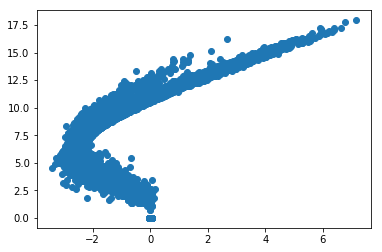

In [28]:
plt.scatter(DX_bias_array, np.log(DX_marg_freq.marg_freq.values+1))

Get marginal frequency:

In [198]:
cooccur_df = pd.read_csv(path+'all/sepdx1/cooccur_df0820.csv')

In [199]:
DX_freq_dict = defaultdict(float)

In [200]:
cooccur_df.head()

,focal_index,context_index,cooccur_counts
0,24701,1137,2.0
1,27577,18219,43.0
2,29464,18045,1.0
3,26365,25684,5.0
4,25636,8684,14.0


In [201]:
for _, row in cooccur_df.iterrows():
    DX_freq_dict[row.focal_index] += row.cooccur_counts
    DX_freq_dict[row.context_index] += row.cooccur_counts

In [202]:
len(DX_freq_dict)

25393

In [204]:
DX1_marg_freq = pd.DataFrame(dict(DX1=dx_multi.ICD9CM_CODE.values, 
                                  marg_freq=dx_multi.ICD9CM_CODE.apply(lambda x:DX_freq_dict[DX1_dict[x]])))

DX_marg_freq = pd.DataFrame(dict(DX=dx_multi.ICD9CM_CODE.values, 
                                  marg_freq=dx_multi.ICD9CM_CODE.apply(lambda x:DX_freq_dict[DX_dict[x]])))

PR_marg_freq = pd.DataFrame(dict(PR=pr_multi.ICD9CM_CODE.values, 
                                  marg_freq=pr_multi.ICD9CM_CODE.apply(lambda x:DX_freq_dict[PR_dict[x]])))

In [230]:
DX1_marg_freq.to_csv(path+'all/sepdx1/DX1_marg_freq.csv', index=False)

DX_marg_freq.to_csv(path+'all/sepdx1/DX_marg_freq.csv', index=False)

PR_marg_freq.to_csv(path+'all/sepdx1/PR_marg_freq.csv', index=False)

In [10]:
marg_freq = pd.read_csv(path+'all/sepdx1/marginal_freq.csv', dtype={'DX':bytes})

marg_freq = marg_freq.set_index(marg_freq.DX)

In [11]:
not_appear = marg_freq.loc[marg_freq.marg_freq==0, 'DX']

In [44]:
len(DX_freq_dict)

25393

In [13]:
embed_mat.shape

(35952, 200)

In [22]:
DX_cat_clean = [dx for dx in DX_cat if dx not in unclassified if dx not in not_appear]

DX_cat_clean = DX_cat_clean[1:]

In [190]:
DX1_embed_mat = embed_mat[np.array([DX1_dict[dx] for dx in DX_cat_clean]), :]
DX_embed_mat = embed_mat[np.array([DX_dict[dx] for dx in DX_cat_clean]), :]
PR_embed_mat = embed_mat[np.array([PR_dict[pr] for pr in PR_cat[1:]]), :]

In [191]:
tsne = TSNE(n_components=2, init='random', random_state=0)

In [192]:
start = time.time()
DX_tsne = tsne.fit_transform(DX_embed_mat)
print('Time used: {} sec'.format(time.time()-start))

Time used: 86.26013612747192 sec


In [193]:
plot_df = pd.DataFrame(dict(x=DX_tsne[:, 0], y=DX_tsne[:, 1]), index=DX_cat_clean)

CCS category labels:

In [194]:
plot_df = plot_df.assign(ccs_lvl1=[dx_multi.loc[dx, 'CCS_LVL1']+' '+dx_multi.loc[dx, 'CCS_LVL1_LABEL'] for dx in plot_df.index])

In [195]:
plot_df = plot_df.assign(marg_freq=marg_freq.loc[plot_df.index, 'marg_freq'])

plot_df = plot_df.assign(dot_size=plot_df.marg_freq.apply(lambda x:np.log(x+1)**2/5))

In [150]:
plot_df.head(10)

,x,y,ccs_lvl1,marg_freq,dot_size
0010,-8.924175,-16.874761,9 Diseases of the digestive system,66.0,3.535888
0019,-8.428122,-16.784478,9 Diseases of the digestive system,46.0,2.964727
0020,-8.250372,-17.170166,9 Diseases of the digestive system,906.0,9.275608
0021,-8.876140,-16.841060,9 Diseases of the digestive system,48.0,3.029253
0029,-8.832216,-16.880285,9 Diseases of the digestive system,77.0,3.796182
0030,-7.075158,-17.578424,9 Diseases of the digestive system,12799.0,17.887728
0031,-9.736203,-14.057403,1 Infectious and parasitic diseases,2549.0,12.305192
00320,-9.261261,-16.949209,9 Diseases of the digestive system,91.0,4.089314
00321,-2.612608,8.609093,6 Diseases of the nervous system and sense organs,67.0,3.560849
00322,2.452895,-12.785293,8 Diseases of the respiratory system,170.0,5.287341


In [155]:
plot_df = plot_df.assign(label = 'other')

AMI cohort labels:

In [67]:
plot_df.loc[plot_df.index.isin(ami_DX), 'label'] = 'AMI_major'

In [146]:
ami_DX0 = [c for c in ami_DX if c[-1]=='0']
ami_DX1 = [c for c in ami_DX if c[-1]=='1']

plot_df.loc[plot_df.index.isin(ami_DX0), 'label'] = 'Major DX 410x0'
plot_df.loc[plot_df.index.isin(ami_DX1), 'label'] = 'Major DX 410x1'

In [147]:
plot_df.loc[plot_df.index.isin(amidx_top100.index), 'label'] = 'Top 51-100 frequent DX in AMI'
plot_df.loc[plot_df.index.isin(amidx_top50.index), 'label'] = 'Top 21-50 frequent DX in AMI'
plot_df.loc[plot_df.index.isin(amidx_top20.index), 'label'] = 'Top 11-20 frequent DX in AMI'
plot_df.loc[plot_df.index.isin(amidx_top10.index), 'label'] = 'Top 10 frequent DX in AMI'

Diabetes Mellitus, Hyperlipidemia, and Hypertension labels:

In [156]:
htn = [c for c in dx_label.dgns_cd.values if c.startswith('401')]
dm = [c for c in dx_label.dgns_cd.values if c.startswith('2500')]
hl = [c for c in dx_label.dgns_cd.values if c.startswith('2724')]

In [115]:
htn, dm, hl

(['4010', '4011', '4019'], ['25000', '25001', '25002', '25003'], ['2724'])

In [123]:
plot_df.loc[htn, 'label'] = 'Hypertension 401.xx'
plot_df.loc[dm, 'label'] = 'Diabetes Mellitus 250.0x'
plot_df.loc[hl, 'label'] = 'Hyperlipidemia 272.4x'

In [157]:
plot_df.loc[htn, 'label'] = dx_label.loc[htn, 'shortdesc']
plot_df.loc[dm, 'label'] = dx_label.loc[dm, 'shortdesc']
plot_df.loc[hl, 'label'] = dx_label.loc[hl, 'shortdesc']

In [165]:
plot_df.loc[htn, 'label'] = htn
plot_df.loc[dm, 'label'] = dm
plot_df.loc[hl, 'label'] = hl

In [166]:
plot_df.label.value_counts()

other    15064
4019         1
4010         1
25000        1
2724         1
25003        1
25001        1
4011         1
25002        1
Name: label, dtype: int64

In [196]:
#groups = plot_df.groupby('freq_label')
groups = plot_df.groupby('ccs_lvl1')
gkey = groups.size().sort_values(ascending=False).index

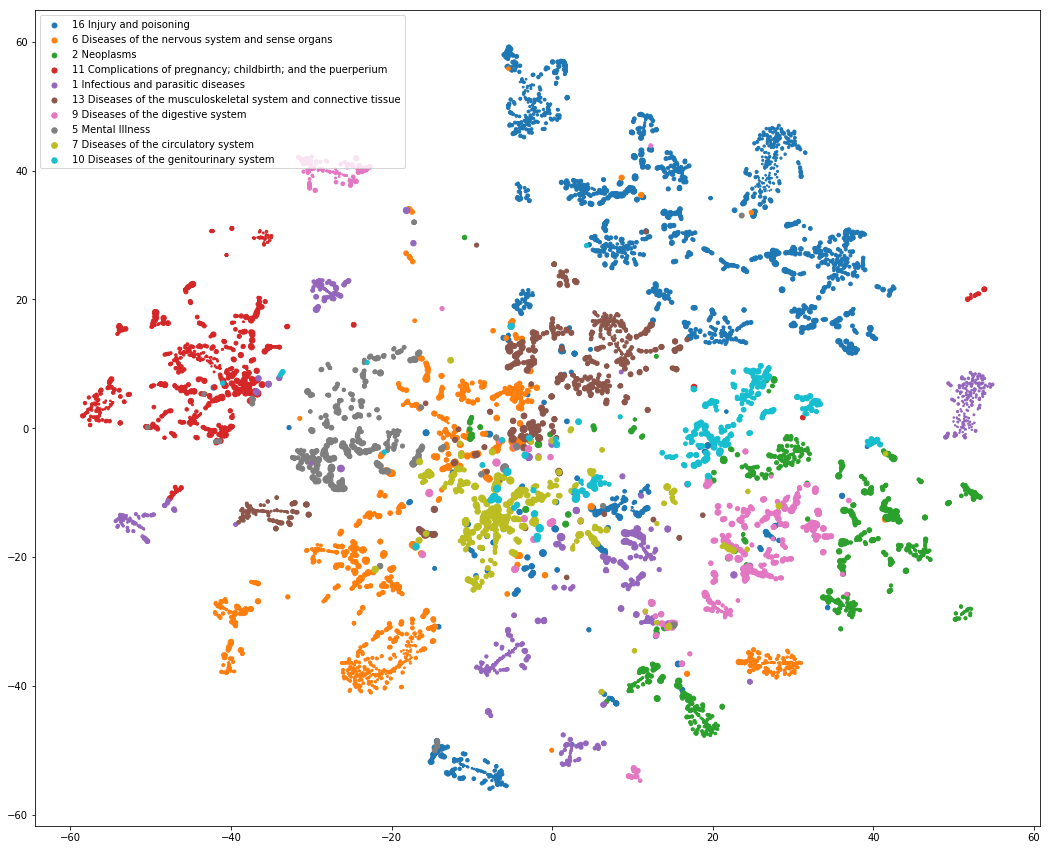

In [197]:
fig, ax = plt.subplots(figsize=(18, 15))
for name in gkey[:10]:
    group = groups.get_group(name)
    ax.scatter(group.x, group.y, marker='o', s=group.dot_size.values, label=name)
    #plt.annotate(name, xy=(group.x.values, group.y.values), xytext=(group.x.values, group.y.values))
ax.legend()
plt.savefig('output/embed.png', dpi=200)

In [155]:
top_fine_cat = ami_ccs.finest_non_empty.value_counts().iloc[:10].index
plot_subdf = plot_df.loc[plot_df.fine_group.isin(top_fine_cat)]

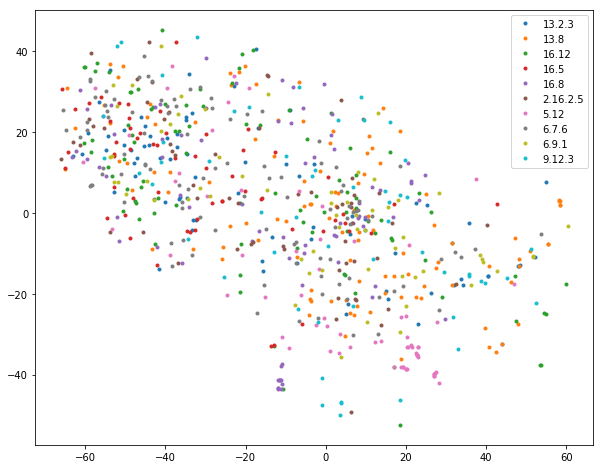

In [156]:
groups = plot_subdf.groupby('fine_group')
fig, ax = plt.subplots(figsize=(10, 8))
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=3, label=name)
ax.legend()

### backups

In [89]:
mat = K.variable(embed_mat)

In [90]:
mat.shape

TensorShape([Dimension(34093), Dimension(100)])

In [23]:
K.get_value(mat)

array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)

In [92]:
embeds = K.gather(mat, code_ind)

In [93]:
embeds.shape

TensorShape([Dimension(18529), Dimension(100)])

In [94]:
parents = K.gather(mat, parent_ind)

In [95]:
parents.shape

TensorShape([Dimension(18529), Dimension(100)])

In [96]:
diff = embeds - parents

In [99]:
penalty = K.sum(K.square(diff))

In [100]:
K.get_value(penalty)

27770.062

In [34]:
K.get_value(submat)

array([[4., 5., 6.],
       [1., 2., 3.]], dtype=float32)